# Unsupervised Learning on TripAdvisor Reviews

This notebook demonstrates unsupervised learning techniques (clustering and topic modeling) on the TripAdvisor review dataset.


## 1. Environment Setup & Imports

Import all required libraries and ensure necessary NLTK resources are downloaded.

In [11]:
import pandas as pd
from datasets import load_dataset
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sentence_transformers import SentenceTransformer
import numpy as np
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasduport/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucasduport/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucasduport/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Load and Preview the Dataset

We use the TripAdvisor review dataset from Hugging Face. To ensure balanced classes for unsupervised analysis, we undersample to the smallest class.

In [2]:
ds = load_dataset('jniimi/tripadvisor-review-rating')
df = pd.DataFrame(ds['train'])

# Balance the dataset by 'overall' (undersample to smallest class)
min_count = df['overall'].value_counts().min()
balanced_df = df.groupby('overall', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

print("Review count per rating (balanced):")
print(balanced_df['overall'].value_counts().sort_index())

Review count per rating (balanced):
overall
1.0    8045
2.0    8045
3.0    8045
4.0    8045
5.0    8045
Name: count, dtype: int64


/var/folders/2w/4qqf8r510cx2s9p_s4gc5z9c0000gn/T/ipykernel_60672/2487194343.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('overall', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


> **Note:** The dataset is now balanced across all overall ratings. All subsequent analysis will use `balanced_df`.

## 3. Text Preprocessing

We sample reviews for efficiency, lowercase, tokenize, remove stopwords (including domain-specific ones) and lemmatize.

In [3]:
# Sample 10000 reviews for processing efficiency
sample_df = balanced_df.sample(10000, random_state=42).reset_index(drop=True)
# sample_df = balanced_df.copy()

# Get standard stopwords and add domain-specific ones
stop_words = set(stopwords.words('english'))
domain_stopwords = {
    'hotel', 'room', 'stay', 'night', 'rooms', 'stayed', 'would', 'could', 'one', 'two',
    'day', 'went', 'going', 'get', 'got', 'told', 'said', 'upon', 'also', 'much',
    # US big cities and variants
    'new', 'york', 'nyc', 'los', 'angeles', 'la', 'chicago', 'houston', 'phoenix', 'philadelphia',
    'san', 'antonio', 'diego', 'dallas', 'jose', 'austin', 'jacksonville', 'fort', 'worth', 'columbus',
    'charlotte', 'indianapolis', 'seattle', 'denver', 'washington', 'boston', 'el', 'paso', 'nashville',
    'detroit', 'oklahoma', 'portland', 'vegas', 'louis', 'baltimore', 'milwaukee', 'albuquerque',
    'tucson', 'fresno', 'sacramento', 'mesa', 'kansas', 'atlanta', 'omaha', 'colorado', 'raleigh',
    'miami', 'long', 'beach', 'virginia', 'oakland', 'minneapolis', 'tulsa', 'arlington', 'tampa',
    'newark', 'orleans', 'pittsburgh', 'cincinnati', 'orlando', 'cleveland', 'anaheim', 'honolulu',
    'st', 'louis', 'san francisco', 'francisco'
}
stop_words.update(domain_stopwords)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
    return tokens

def preprocess_for_display(text):
    return ' '.join(preprocess_text(text))

sample_df['tokens'] = sample_df['text'].apply(preprocess_text)
sample_df['clean_text'] = sample_df['text'].apply(preprocess_for_display)
sample_df[['clean_text']].head()

,clean_text
0,staff sutton place professional work hard make...
1,paper written pen towel bathroom far away tub ...
2,upgrade presidential suite sweet contracted la...
3,nice overcharged asked club level arrival long...
4,entrance impressive shame let floor dull need ...


## 4. Sentence Embeddings (SBERT)

We use Sentence-BERT to generate embeddings for our reviews, which capture semantic meaning better than TF-IDF vectors.

In [4]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = sbert_model.encode(sample_df['clean_text'].tolist(), show_progress_bar=True)

print(f"Embedding shape: {embeddings.shape}")

Batches: 100%|██████████| 313/313 [00:34<00:00,  9.09it/s]



Embedding shape: (10000, 384)


## 5. Dimensionality Reduction (UMAP)

UMAP works better than PCA for visualizing high-dimensional embeddings. It preserves both local and global structure.

/Users/lucasduport/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


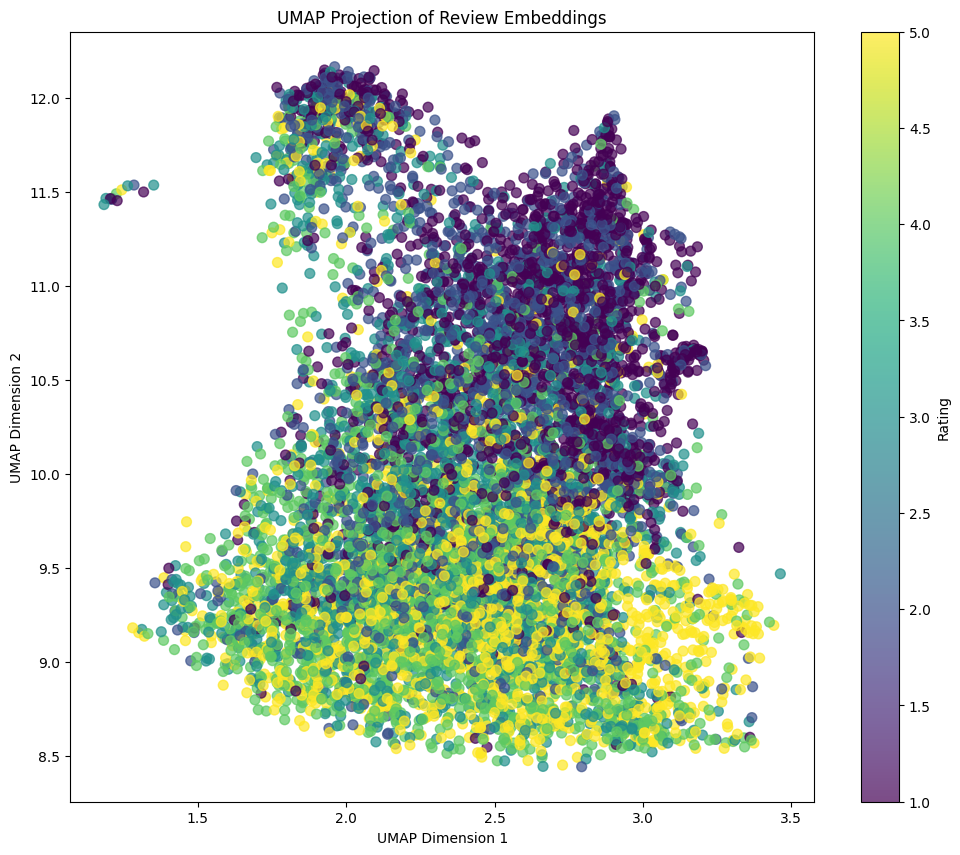

In [5]:
umap_reducer = umap.UMAP(n_components=50, n_jobs=1, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_umap[:, 0], 
    embeddings_umap[:, 1],
    c=sample_df['overall'],
    cmap='viridis', 
    alpha=0.7, 
    s=50
)
plt.colorbar(scatter, label='Rating')
plt.title('UMAP Projection of Review Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

/Users/lucasduport/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lucasduport/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


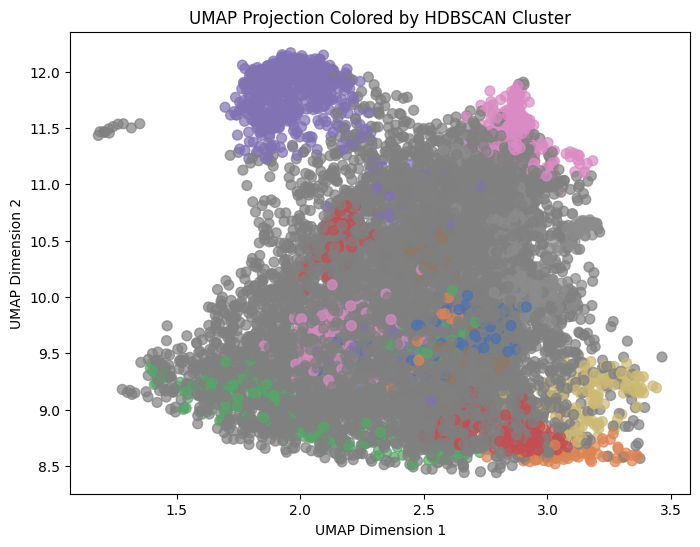

In [6]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=28, prediction_data=True)
hdbscan_labels = hdbscan_clusterer.fit_predict(embeddings_umap)
sample_df['hdbscan_cluster'] = hdbscan_labels

plt.figure(figsize=(8, 6))
palette = sns.color_palette("deep", np.max(hdbscan_labels) + 1)
colors = [palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in hdbscan_labels]
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=colors, alpha=0.7, s=50)
plt.title('UMAP Projection Colored by HDBSCAN Cluster')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


In [7]:
for cluster_id in sorted(sample_df['hdbscan_cluster'].unique()):
    cluster_reviews = sample_df[sample_df['hdbscan_cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_reviews)})")
    
    print("Rating distribution:")
    print(cluster_reviews['overall'].value_counts().sort_index())
    
    all_tokens = [token for tokens in cluster_reviews['tokens'] for token in tokens]
    token_counts = pd.Series(all_tokens).value_counts()
    print("Top 10 tokens:")
    print(token_counts.head(10))
    print("="*60)


Cluster -1 (n=7279)
Rating distribution:
overall
1.0    1328
2.0    1446
3.0    1483
4.0    1541
5.0    1481
Name: count, dtype: int64
Top 10 tokens:
staff       4161
great       3502
good        3407
time        3343
location    3138
bed         3101
nice        2984
service     2677
desk        2564
clean       2552
Name: count, dtype: int64

Cluster 0 (n=38)
Rating distribution:
overall
1.0     1
2.0     3
3.0     5
4.0    13
5.0    16
Name: count, dtype: int64
Top 10 tokens:
kimpton     59
great       33
staff       27
hotel       24
location    19
bar         18
door        18
service     17
bathroom    16
hour        15
Name: count, dtype: int64

Cluster 1 (n=40)
Rating distribution:
overall
1.0    12
2.0    11
3.0    13
4.0     3
5.0     1
Name: count, dtype: int64
Top 10 tokens:
wifi        37
internet    35
work        23
free        13
business    12
time        12
service     12
good        11
need        11
nice        10
Name: count, dtype: int64

Cluster 2 (n=76)
Rating 

## 6. Topic Modeling with LDA

As an alternative to clustering, we can use topic modeling to discover the abstract 'topics' present in our reviews. Let's apply Latent Dirichlet Allocation (LDA) and visualize with pyLDAvis.

In [8]:
# Use CountVectorizer for LDA (Dirichlet distribution assumption)
count_vectorizer = CountVectorizer(max_df=0.9, min_df=5, max_features=1000, ngram_range=(1, 2))
count_matrix = count_vectorizer.fit_transform(sample_df['clean_text'])

optimal_topics = 10

In [9]:
lda_model = LatentDirichletAllocation(n_components=optimal_topics, 
                                      learning_method='online',
                                      random_state=42,
                                      n_jobs=-1,
                                      max_iter=100)
lda_output = lda_model.fit_transform(count_matrix)

sample_df['dominant_topic'] = lda_output.argmax(axis=1)
sample_df['topic_prob'] = lda_output.max(axis=1)

feature_names = count_vectorizer.get_feature_names_out()
topic_terms = {}

print("Top terms per topic:")
for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[:-11:-1]  # top 10 keywords
    top_features = [feature_names[i] for i in top_features_ind]
    topic_terms[topic_idx] = top_features
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/lucasduport/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=60672) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/lucasduport/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=60672) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can eit

Top terms per topic:
Topic 0: internet, free, suite, floor, coffee, parking, per, use, charge, price
Topic 1: staff, great, friendly, good, location, nice, clean, helpful, breakfast, service
Topic 2: water, hot, air, shower, cold, pool, others, resort, hot water, heat
Topic 3: desk, front, front desk, desk staff, called, security, clerk, called front, key, desk clerk
Topic 4: like, place, bed, old, floor, bathroom, noise, dirty, door, wall
Topic 5: great, location, time, good, walk, street, restaurant, nice, area, view
Topic 6: time, car, parking, like, door, next, card, back, make, husband
Topic 7: service, time, back, asked, check, never, manager, call, staff, even
Topic 8: walking, distance, inn, walking distance, central, within, holiday, hyatt, within walking, park
Topic 9: bed, bathroom, small, shower, shuttle, breakfast, king, towel, comfortable, size


In [12]:

panel = pyLDAvis.lda_model.prepare(lda_model, count_matrix, count_vectorizer, sort_topics=False)
pyLDAvis.enable_notebook()

pyLDAvis.display(panel)

### Comparing LDA topics with HDBSCAN clusters

Now let's compare our findings from both approaches:

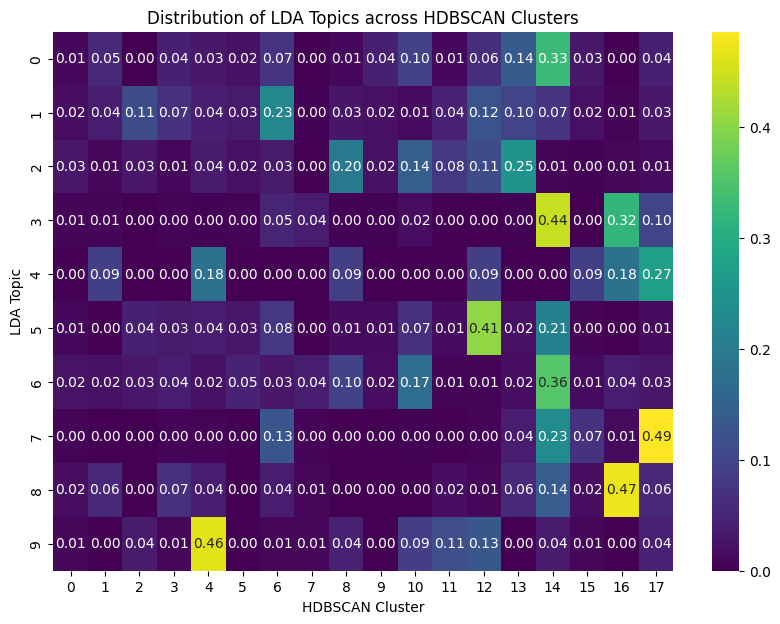

In [ ]:
clustered_reviews = sample_df[sample_df['hdbscan_cluster'] >= 0]

cross_tab = pd.crosstab(clustered_reviews['dominant_topic'], 
                       clustered_reviews['hdbscan_cluster'], 
                       normalize='index')

plt.figure(figsize=(10, 7))
sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt=".2f")
plt.title('Distribution of LDA Topics across HDBSCAN Clusters')
plt.xlabel('HDBSCAN Cluster')
plt.ylabel('LDA Topic')
plt.show()

### Visualizing Topics vs Clusters in UMAP Space

Let's visualize both LDA topics and HDBSCAN clusters on the same UMAP projection:

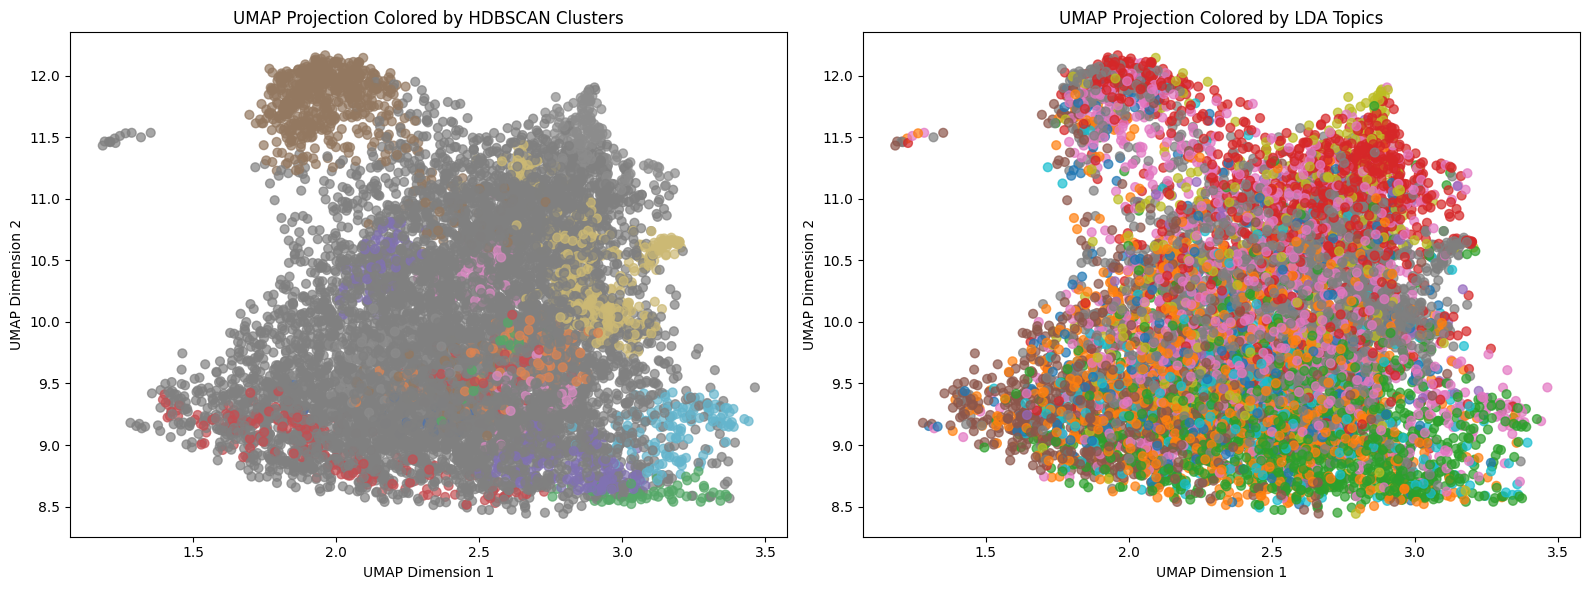

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

palette_hdbscan = sns.color_palette("deep", np.max(sample_df['hdbscan_cluster']) + 2)  # +2 for noise points
colors_hdbscan = [palette_hdbscan[x+1] if x >= 0 else (0.5, 0.5, 0.5) for x in sample_df['hdbscan_cluster']]
scatter1 = ax1.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                      c=colors_hdbscan, alpha=0.7, s=40)
ax1.set_title('UMAP Projection Colored by HDBSCAN Clusters')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')

palette_lda = sns.color_palette("tab10", optimal_topics)
colors_lda = [palette_lda[x] for x in sample_df['dominant_topic']]
scatter2 = ax2.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                      c=colors_lda, alpha=0.7, s=40)
ax2.set_title('UMAP Projection Colored by LDA Topics')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

## 7. Comparing Clustering vs. Topic Modeling

Both HDBSCAN clustering (on SBERT embeddings) and LDA topic modeling provide complementary insights into the TripAdvisor reviews:

- **HDBSCAN**: Finds natural, semantically similar groups of reviews, can identify noise, but clusters are less interpretable.
- **LDA**: Extracts interpretable topics with top keywords, allows reviews to belong to multiple topics, but requires specifying the number of topics and ignores word order/context.

Use clustering for grouping similar reviews and topic modeling for understanding main themes. Combining both approaches can yield richer analysis.

## 8. Summary

We applied unsupervised learning to TripAdvisor reviews using:

- **SBERT + HDBSCAN** for clustering reviews by semantic similarity.
- **LDA** for extracting main topics and their keywords.